In [135]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import time

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
device

'cpu'

In [136]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
        nn.Linear(1,10),
        nn.Sigmoid(),
        nn.Linear(10,1, bias=False)
        )
        
    def forward(self, x):
        N = self.layers(x)
        return N

In [137]:
def training(x, loss_fn, optimizer):
    x = x.to(device)
    def closure():
        loss = loss_fn(x)
        optimizer.zero_grad()
        loss.backward()
        return loss
    torch.nn.utils.clip_grad_value_(model.parameters(), 2)
    optimizer.step(closure)  

In [138]:
Phi_0 = torch.Tensor(np.loadtxt("file.txt")).reshape(200,1)
Phi_0.shape

torch.Size([200, 1])

In [139]:
beta = 2
global Z
Z = 1
global e
#e = -1.602e-19
e = -1
global hbar
#hbar = 1.054e-34
hbar = 1
global m
#m = 9.109e-31
m = 1
global l
l = 0
global Phi_0

V = lambda r: -(Z*e**2)/r
Phi_aux = lambda r: r*torch.exp(-beta*r) * model.forward(r)
Phi_t = lambda r: Phi_aux(r) - Phi_0*torch.trapezoid(Phi_0[100:]*Phi_aux(r)[100:], r[100:],dim=0)

In [140]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Linear)):
            nn.init.xavier_normal_(m.weight.data, gain=0.20)

In [141]:
def loss_fn(r):
    r.requires_grad = True
    
    Phi = Phi_t(r)    
    Phi_t_r = torch.autograd.grad(Phi, r, grad_outputs=torch.ones_like(Phi), create_graph=True)[0]
    Phi_t_r_r = torch.autograd.grad(Phi_t_r, r, grad_outputs=torch.ones_like(Phi_t_r), create_graph=True)[0]
    H_Phi = -(hbar**2/(2*m))*Phi_t_r_r + (l*(l+1)*hbar**2/(2*m*r**2) + V(r))*Phi
    
    norm = torch.trapezoid(Phi[100:]**2,r[100:],dim=0) # integral over r=0 to 6

    prom = Phi.size()[0]
    
    global E
    E = torch.trapezoid(Phi[100:]*H_Phi[100:],r[100:],dim=0)/norm 
    
    
    return (torch.mean((H_Phi[100:] - E*Phi[100:])**2)*prom)/norm #multiply by m to avoit division by m in the mean function of torh 

In [142]:
upper_r = 6
lower_r = -6
steps = 200
R_train = torch.Tensor(np.linspace(lower_r, upper_r, steps)[:,None])
epoch = 30000
lr = 1 
Phis_t = []
Es = []
lss = []
epochs = []

Phi_0 = Phi_0/torch.sqrt(torch.trapezoid(Phi_0[100:]**2,R_train[100:],dim=0))


start = time.time()

model = NeuralNetwork().to(device)
initialize_weights(model)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
for t in range(epoch):
    loss = loss_fn(R_train.to(device))
    print(f"Epoch {t+1}\n ---------------------- loss: {loss}")
    training(R_train, loss_fn, optimizer)
    if t%100 == 0:
        Phis_t.append(Phi_t(R_train).detach().numpy())
        Es.append(E.detach().numpy())
        lss.append(loss.detach().numpy())
        epochs.append(t)
Es = np.squeeze(Es)
lss = np.squeeze(lss)
Phis_t = np.squeeze(Phis_t)
print("Done!")

end = time.time()
print(end - start)

Epoch 1
 ---------------------- loss: tensor([1.7697e+11], grad_fn=<DivBackward0>)
Epoch 2
 ---------------------- loss: tensor([1.7695e+11], grad_fn=<DivBackward0>)
Epoch 3
 ---------------------- loss: tensor([1.5571e+11], grad_fn=<DivBackward0>)
Epoch 4
 ---------------------- loss: tensor([1.3159e+11], grad_fn=<DivBackward0>)
Epoch 5
 ---------------------- loss: tensor([9.8302e+10], grad_fn=<DivBackward0>)
Epoch 6
 ---------------------- loss: tensor([6.2843e+10], grad_fn=<DivBackward0>)
Epoch 7
 ---------------------- loss: tensor([4.0415e+10], grad_fn=<DivBackward0>)
Epoch 8
 ---------------------- loss: tensor([3.6566e+10], grad_fn=<DivBackward0>)
Epoch 9
 ---------------------- loss: tensor([3.3733e+10], grad_fn=<DivBackward0>)
Epoch 10
 ---------------------- loss: tensor([2.7903e+10], grad_fn=<DivBackward0>)
Epoch 11
 ---------------------- loss: tensor([2.1565e+10], grad_fn=<DivBackward0>)
Epoch 12
 ---------------------- loss: tensor([1.5858e+10], grad_fn=<DivBackward0>)
E

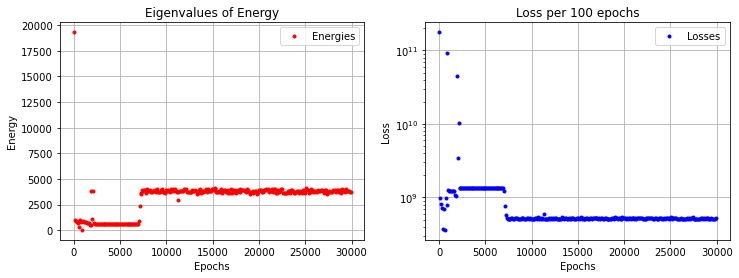

In [143]:
plt.subplots(1,2,figsize=(12,4))
plt.subplot(121)
plt.plot(epochs, Es, "r.", label="Energies")
plt.title("Eigenvalues of Energy")
#plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Energy")
plt.grid()
plt.legend(loc="best")
plt.subplot(122)
plt.plot(epochs, lss, "b.", label="Losses")
plt.title("Loss per 100 epochs")
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend(loc="best")
plt.show()

IndexError: index 300 is out of bounds for axis 0 with size 300

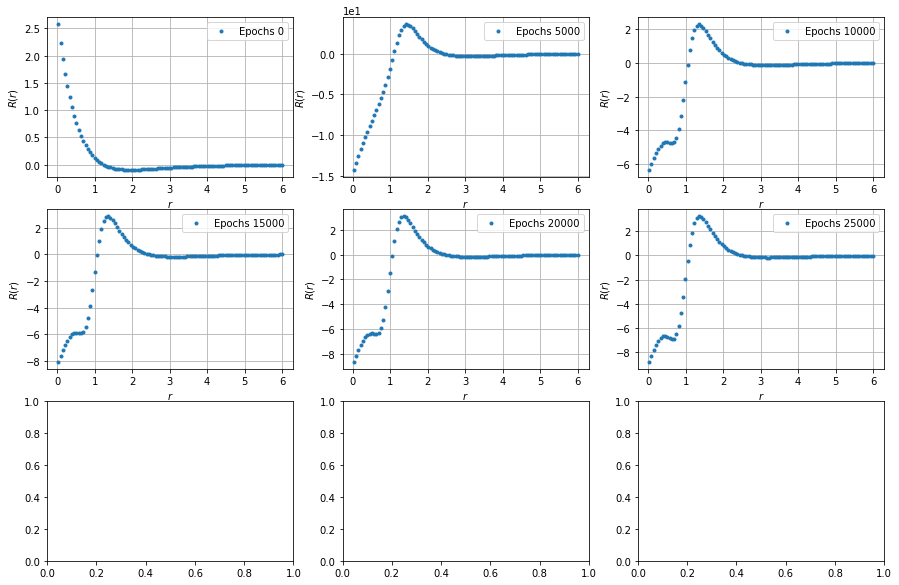

In [144]:
rr = np.linspace(lower_r, upper_r, steps)[:,None]
fig, axs = plt.subplots(3,3,figsize=(15,10))

fil = 0
col = 0
for i in range(0,9):
    yy = Phis_t[50*i]
    yy = yy.reshape((200,1))
    axs[fil,col].plot(rr[100:], np.divide(yy[100:], rr[100:]), ".", label=f"Epochs {epochs[50*i]}")
    axs[fil,col].set_xlabel("$r$")
    axs[fil,col].set_ylabel("$R(r)$")
    axs[fil,col].legend(loc="best")
    axs[fil,col].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    axs[fil,col].grid()
    if col == 2:
       col = 0
       fil = fil+1
    else:
       col = col+1
plt.tight_layout()
plt.show()  

In [145]:
Es

array([19312.828   ,   988.2903  ,   899.7942  ,   816.84503 ,
         739.19995 ,   931.2053  ,   278.98962 ,   966.4942  ,
         833.20734 ,    35.731415,   882.9539  ,   818.0418  ,
         784.1707  ,   763.6379  ,   748.1966  ,   733.5617  ,
         713.1161  ,   486.14755 ,   544.25525 ,  3811.6694  ,
        1061.2048  ,  3858.952   ,   719.762   ,   586.30286 ,
         578.8756  ,   577.8769  ,   577.782   ,   577.75415 ,
         577.7607  ,   577.75336 ,   577.7608  ,   577.747   ,
         577.7615  ,   577.7587  ,   577.75    ,   577.7592  ,
         577.7579  ,   577.76337 ,   577.7639  ,   577.7407  ,
         577.7521  ,   577.75366 ,   577.75006 ,   577.7534  ,
         577.7568  ,   577.7721  ,   577.76953 ,   577.77515 ,
         577.7712  ,   577.75836 ,   577.7494  ,   577.7727  ,
         577.7537  ,   577.75946 ,   577.7526  ,   577.7519  ,
         577.7505  ,   577.76605 ,   577.752   ,   577.7474  ,
         577.7643  ,   577.7611  ,   577.7684  ,   577.

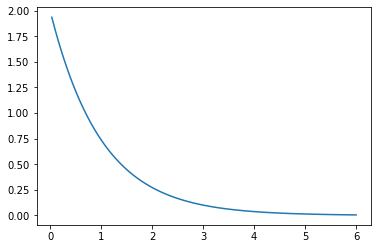

In [152]:
plt.plot(R_train.detach().numpy()[100:],Phi_0[100:]/R_train.detach().numpy()[100:])